Machine Learning Job Pair (Classification)
=======

## System Architecture

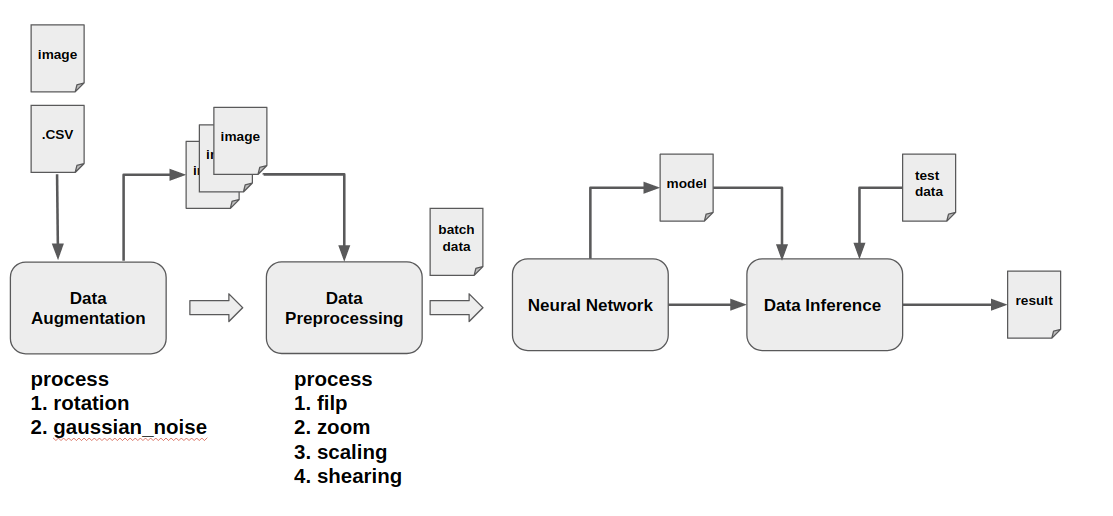

## 1. Requirement
* python 2.x.x                                                         

* Tensorflow 2.0  

* CUDA 10.2  

* Cudnn >= 7.6.2  

* Pillow, SciPy, six, numpy, OpenCV 3.x.x

## 2. Environment  

* Ubuntu 18.04
* Nvidia-docker 2.0.3
* GeForce GTX1070 8G

### Data Augmentation  
* Traing 할수있는 데이터의 수를 늘리고자 회전, 가우시안 노이즈를 적용.

In [ ]:
import csv, os
import cv2
import preprocess.augmentation as aug #가우시안 노이즈를 사용하기위한 외부소스

data_file_path = "/data/faces_images" # 데이터의 위치와 훈련데이터 정보가 있는 csv파일 경로
label_file_path = "/data/train_vision.csv" 

f = open('/data/noise_train_vision.csv','w')
wr = csv.writer(f)
wr.writerow(['filename','label'])

with open(label_file_path) as path_list:
    for data in enumerate(path_list):
        if data[0] is 0: continue
        filename, label = data[1].split(",")
        filepath = os.path.join(data_file_path,filename)
        
        ### 가우시안 노이즈 이미지 생성
        img = cv2.imread(filepath)
        noised_img = aug.gaussian_noise(img, mean=0, var =10) 
        
        ### Label파일 생성
        wr.writerow([filename, int(label)])
        cv2.imwrite(os.path.join(data_file_path,'noised_'+filename), noised_img)
        wr.writerow(['noised_'+filename, int(label)])
        
        '''
        for i in range(1,4):
            img = img.rotate(90)
            img.save(os.path.join(data_file_path,'rot'+str(90*i)+'_'+filename))
            wr.writerow(['rot'+str(90*i)+'_'+filename, int(label)])
        '''

### Data Preprocessing
* 주어진 데이터 csv를 참고하여 데이터를 읽은 후 전처리하는 단계입니다.
* keras의 데이터생성 함수의 경우 폴더 내부의 이미지를 읽어들여 Data Generator를 생성하기 때문에 이미지의 파일경로와 라벨을 가지고 데이터를 생성하는 flow_from_mapfile 구현.  
* Feature 잘 분류하기 위해 데이터 처리 과정에서 horizontal flip, zoom, shear, rescale 적용.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os, sys
import numpy as np
import preprocess.image as image
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
import random

data_file_path = "/data/faces_images"
label_file_path = "/data/train_vision.csv"
initial_learning_rate = 0.001 
image_size = 224
class_num = 6
batch_size = 16
epoch = 60

### GPU Memory 사용량을 제어하기 위한 코드 
### 기존의 tensorflow 1.x 버전의 Session을 이용하여 할당하는데 필요한 memory만을 사용.
'''
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.compat.v1.Session(config=config))
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# 프로그램 시작시에 메모리 증가가 설정되어야만 합니다

### 데이터 생성을 위한 path와 label리스트 생성
filenames = []
labels = []
with open(label_file_path) as path_list:
    for data in enumerate(path_list):
        if data[0] is 0:
            continue
            
        filename, label = data[1].split(",")
        filenames.append(os.path.join(data_file_path,filename))
        labels.append(int(label)-1)
        
    '''
    random.seed(1)    
    random.shuffle(filenames)
    random.shuffle(labels)
    '''
    
    print('Found %d images for training.' % (len(filenames)))
    
class_num = list(range(class_num))

'''
Class ImageDataGenerator
- Training에 사용되는 데이터를 생성하고 queue에 전달해주는 iterator.
  전달시 설정한 범위에서 random으로 filp, zoom, shearing을 수행하여 데이터를 보낸다.
'''
train_datagen = image.ImageDataGenerator(rescale=1. / 255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True)

'''
Class DataPathIterator (기존의 DirectoryInterator를 수정)
- flow_from_mapfile의 return값. filename리스트를 읽어 데이터로 변환하며 random index를 통해 Training시 data batch
  를 random하게 구성하여 전달.

argment : 
        get_batches_of_transformed_samples : random index생성 및 이미지 로드를 하며 각 데이터 라벨에 대해 
        one-hot encording을 수행한다.
        
        next : 데이터의 다음 batch를 반환.
'''
train_generator = train_datagen.flow_from_mapfile(class_num,filenames,labels,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            class_mode='categorical')


### Neural Network Training
* 전처리한 데이터를 사용하여 신경망을 훈련하는 단계로 훈련에 사용되는 Optimizer 종류, learning rate, epoch수 등을 조정하여 최적의 모델을 만드는 단계입니다.
* tensorflow에서 지원하는 다양한 신경망을 편리하게 사용하기 위해 net_factory 구현.
* queue를 사용하여 데이터 흐름을 제어합니다.
* jupyter notebook의 경우 한 셀의 job이 끝나도 GPU에 할당된 메모리를 반환하지 않습니다. Training이 끝난 후 커널을 종료한 뒤 다시시작 해주세요. 이후 Inference부터 시작합니다.  

In [ ]:
import net.nets_factory as nets_factory
from tensorflow.keras import optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import GeneratorEnqueuer
from tensorflow.keras.utils import OrderedEnqueuer


'''
network list :
    image size(224) : resnet50, resnet101, resnet152, resnet50_v2, resnet101_v2, resnet152_v2, vgg16, vgg19,
                      densenet121, densenet169, densenet201, NASNet
    image size(299) : inception_v3, inception_resnet_v2, xception

'''
network_name = 'vgg19' #사용할 network 입력
save_model_path = "/home/june/model" #model이 저장될 path
network_fn = nets_factory.get_network(network_name)
model = network_fn(include_top=True, weights=None, classes=len(class_num))

'''
scheduler를 이용한 learning rate 적용. overfitting을 방지하기 위해 step수에 따라 
learning rate가 지수적으로 감소합니다.
'''
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                    decay_steps=10000,
                                                    decay_rate=0.96,
                                                    staircase=True)


'''
network의 weight를 최적화하는 과정에서 사용되는 알고리즘입니다.
주로 사용되는 SGD(Stochastic Gradient Descent), RMSprop(Root Mean Square Propogation) 
Adam(ADAptive with Momentum)을 사용하여 back Propogation을 진행하였습니다.
'''
#optimizer = optimizers.SGD(learning_rate = lr_schedule)
optimizer = optimizers.RMSprop(learning_rate = lr_schedule)
#optimizer = optimizers.Adam(learning_rate = lr_schedule, beta_1 = 0.9,
                            #beta_2 = 0.999, epsilon = 1e-08, decay= 0.)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

'''
iterator를 사용하여 생성한 data batch를 대기열에 넣기위해 queue를 생성합니다.
'''
def create_data_queue(train_generator):
    is_sequence = isinstance(train_generator, Sequence)
    wait_time = 0.01
    if is_sequence:
        enqueuer = OrderedEnqueuer(train_generator,
                                use_multiprocessing=False,
                                shuffle = True)
    else:
        enqueuer = GeneratorEnqueuer(train_generator,
                                use_multiprocessing =False,
                                wait_time = wait_time)
    return enqueuer


# queue생성
enqueuer = create_data_queue(train_generator)
enqueuer.start(workers = 1, max_queue_size=10)
output_generator = enqueuer.get()
accuracy_mean = 0.
current_step = 0
current_epoch = 1
max_iter = int(len(filenames) / batch_size)

'''
입력된 epoch만큼의 훈련을 진행합니다. 
batch별 데이터를 실시간으로 확인하기위해 train_on_batch를 사용.
'''
try:
    while current_step < epoch * max_iter:
        if current_step%max_iter == 0:
            accuracy_mean = 0.
            current_epoch = int(current_step/max_iter)
            
        # queue를 사용한 데이터 제어                
        generator_output = next(output_generator)
        x, y = generator_output
        loss, accuracy = model.train_on_batch(x,y)            
        accuracy_mean = ((accuracy_mean * current_step-(max_iter*current_epoch))+accuracy) / (current_step-(max_iter*current_epoch)+1)
        
        #데이터 출력 : epoch, loss, accuracy, step        
        sys.stdout.write('\r>> epoch : %d, loss : %f, accuracy : %f, step : %d/%d ' % (current_epoch, loss, accuracy, current_step, epoch * max_iter))
        sys.stdout.flush()
        current_step += 1
        
        # model save 
        if current_step%1000 ==0 :
            model.save_weights(os.path.join(save_model_path,'%s_%d.ckpt'%(network_name,current_step)))
            
except Exception as ex:
    print(ex)
    enqueuer.stop(timeout=0.01)
    
enqueuer.stop(timeout=0.01) #queue 종료
model.save_weights(os.path.join(save_model_path,'%s_%d.ckpt'%(network_name,current_epoch)))
K.clear_session() 

### Data Inference
* 훈련한 모델을 가지고 테스트를 진행하는 단계입니다.
* 다양한 모델을 학습하고 결과를 놓고 투표하여 최종 Class를 정합니다.

In [ ]:
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import optimizers
import net.nets_factory as nets_factory
import csv, os
import numpy as np
import tensorflow as tf

def load_image(image_file_path):
        img = kimage.load_img(image_file_path, target_size=(image_size, image_size))
        x = kimage.img_to_array(img)
        x /= 255.
        return x
    
result = []
test_file_path = "/data/test_vision.csv"
data_file_path = "/data/faces_images"
save_model_path = "/home/june/model"
image_size = 224

'''
test 데이터를 분류하기위해 훈련된 model(resnet50, resnet152, inception_resnet, inception_v3)을 로드합니다. 
만약 multi-gpu를 사용할 수 있다면 모델별로 GPU 할당을 다르게 할 수 있습니다.

#image_sizes = [224,299,299,224,224]
network_list = ['resnet50_v2', 'inception_resnet_v2', 'inception_v3', 'vgg19','resnet152_v2']
model_list = []
for net in network_list:
    network_fn = nets_factory.get_network(net)
    model_list.append(network_fn(include_top=True, weights=None, classes=6))
'''

network_fn = nets_factory.get_network('resnet50_v2')
model = network_fn(include_top=True, weights=None, classes=6)
model.load_weights(os.path.join(save_model_path,"rms_resnet50_v2_60.ckpt"))

count = collections.Counter()
stack = list(range(6))
with open(test_file_path) as path_list:
    for image_path in enumerate(path_list):
        if image_path[0] is 0 : continue
        img = load_image(os.path.join(data_file_path,image_path[1].split("\n")[0]))
        x = np.expand_dims(img, axis=0)
        '''
        for model in model_list:
            softmax = model.predict(x, batch_size=1)
            stack[np.asarray(softmax).argmax()] += 1
        result.append(np.asarray(stack).argmax() + 1)
        '''
        softmax = model.predict(x, batch_size=1)
        result.append(np.asarray(softmax).argmax() + 1)  #결과로 나온 softmax값중 가장 큰값의 index를 반환합니다.
        
# 결과파일 저장        
f = open('/data/result_rms_resnet50V2_22.csv','w')
wr = csv.writer(f)
wr.writerow(['prediction'])
for i in result:
    wr.writerow([i])
f.close()